<h1 align="center">DAY 5 Workshop SWDB 2024 </h1> 
<h3 align="center">Thursday, August 23rd, 2024</h3> 
<h3 align="center">How does network dynamics govern behavior?</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h2>Objectives</h2>
    
<p>By the end of this lesson, you will be able to

<p>-Think about physical and biological systems in terms of states and dynamics
<p>-Visualize the network state evolution of a recurrent neural network
<p>-Identify the linear dynamics around fixed points
<p>-Think critically about the dynamical systems that implement various tasks.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The Origins of Dynamics: </h2> 
<p>from Steve Strogatz, Nonlinear Dynamics and Chaos 2018
<p>Although dynamics is an interdisciplinary subject today, it was originally a branch of physics. The subject began in the mid-1600s, when Newton invented differential equations, discovered his laws of motion and universal gravitation, and combined them to explain Kepler's laws of planetary motion. Specifically, Newton solved the two-body problem—the problem of calculating the motion of the earth around the sun, given the inverse-square law of gravitational attraction between them.

<p>Subsequent generations of mathematicians and physicists tried to extend Newton's analytical methods to the three-body problem (e.g., sun, earth, and moon) but curiously this problem turned out to be much more difficult to solve. After decades of effort, it was eventually realized that the three-body problem was essentially impossible to solve, in the sense of obtaining explicit formulas for the motions of the three bodies. At this point the situation seemed hopeless.

<p>The invention of the high-speed computer in the 1950s was a watershed in the history of dynamics. The computer allowed one to experiment with equations in a way that was impossible before, and thereby to develop some intuition about nonlinear systems. Such experiments led to Lorenz’s discovery in 1963 of chaotic motion on a strange attractor, which may have a familiar shape.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Dynamical Systems in Biology </h2> 
<p> As discussed in the lecture, a dynamical system is one that changes in time. There are often inputs to the system that also shape how the state of the system changes in time. Fundamental to thinking about biological systems as dynamical systems is identifying a 'state' of the system that changes in time, and whatever inputs are the relevant ones that might change the way the state evolves in time. At a high level, it's very intuitive to think about how biological systems can be interpretted as having a state. You can be hungry, happy, angry or sad - and that might effect the way you interact with your environment. At a more microscopic level, you can also think about the conformational state of a protein that might change how it interacts with the environment, which other molecules in might form bonds with. In systems neuroscience, we often think of neural activity in terms of the state of all the neurons that we record. Using this framework for thinking about the brain as a dynamical system, we can study how neural computation might be implemented through a dynamical system.
    
<p>In this tutorial, we will discuss dynamical systems in the context of computation and behavior. We reverse engineer the dynamics of recurrent neural networks (RNNs) trained to solve a foraging task using reinforcement learning. At the end, we extrapolate to thinking about the dynamics for various neuroscience tasks.

<p>Through this analysis, we hope to gain a better understanding of how RNNs can solve complex sequential decision-making problems and potentially uncover general principles underlying their computational capabilities that will lead to hypotheses about how brains might implement the same task.</p>
</div>

<!-- # Understanding neural circuit and dynamics with recurrent neural networks
(First draft: Po-Chen Kuo 06.21.2024)
- task trained RNNs
- actor-critic RNNs solving dynamic foraging
- visualize RNN acticities using PCA
- dynamical systems analysis of RNN -->

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Task-trained RNNs with Reinforcement Learning</h2>
<p> Task-driven RNNs are trained to take in a set of inputs and produce corresponding outputs that were designed to match cognitive tasks that animals are trained to perform. This approach is utilized to generate hypotheses about how dynamical systems implement the task of interest. Through in depth analysis of task-trained RNNs, researchers can develop a hypotheses about possible mechanisms that may be used in the brain to implement the same task. 
        
<p>Task-trained RNNs can be combined with reinforcement learning (RL) techniques to model how neural systems learn to perform tasks through interaction with their environment. Two popular RL methods used with RNNs are:

<p>Policy Gradient Method: This is a type of RL algorithm that directly optimizes the policy (the strategy for choosing actions) to maximize expected rewards. Key features include learning a probability distribution over actions, updating policy parameters in the direction of higher rewards, and being well-suited for continuous action spaces and partially observable environments. In the context of RNNs, the RNN's output can represent action probabilities, the hidden state can maintain information about past observations, and backpropagation through time is used to compute gradients.

<p>Actor-Critic Algorithm: This is an advanced RL method that combines elements of both policy-based and value-based learning. It consists of an Actor, which learns the policy (which actions to take), and a Critic, which learns to estimate the value function (how good the current state is). Key features include reduced variance in policy updates compared to pure policy gradient methods, ability to learn in continuous action spaces, and often more stability and sample-efficiency than pure policy gradient methods. In the context of RNNs, the network can be split into two parts for the actor and critic, with the actor part outputting action probabilities and the critic part estimating state values. Both parts can share lower-level features.

<p>These RL techniques allow task-trained RNNs to learn complex behaviors over time, mimicking how biological neural systems might learn through experience and reward signals.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Dynamic Foraging: Two Armed Bandit Task </h2>
<p> We will model a two-armed bandit task, that scientists at the Allen Institute for Neural Dynamics are currently training mice to perform. In this task, mice must choose to lick either a left or right lick port. The probability of reward in either arm changes over time. One side is rewarded with a probability of 20% and the other side is rewarded 80% for a given block. Blocks are randomly switched with a uniform distribution between 20-60 trials.

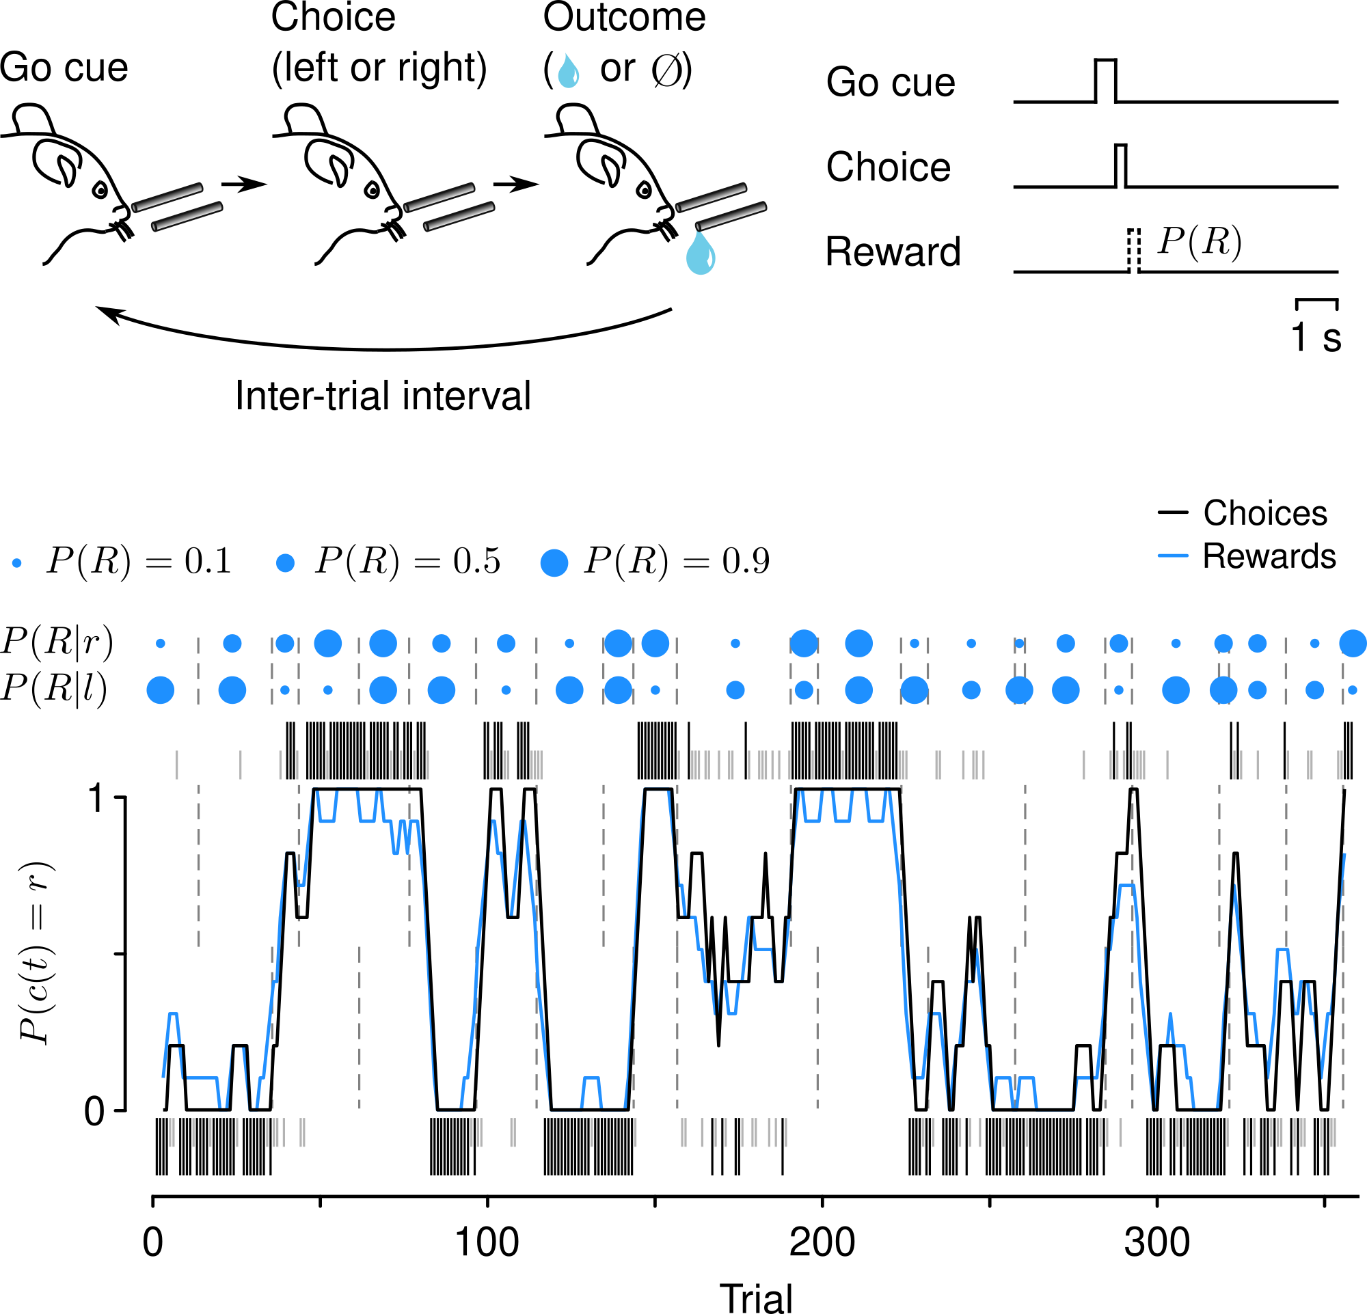

In [52]:
from IPython.display import Image
Image(filename='resources/dyn_foraging_task_schematic.png', width=600) 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>2. Actor-critic RNNs solving dynamic foraging</h2>
<p>As our goals in this tutorial is to analyze RNN circuit and dynamics, here we provide RNNs readily trained to solve the dynamic foraging task. 

<p>We will first look at the behavior of the network from example sessions.

In [53]:
# import
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

On each trial, the RNN receives the action (0/1 indicating left/right) and reward (0 or 1) from the previous trial as input, integrates this input with its hidden states, and generates an action (0/1 indicating left/right) as output

In [54]:
# define hyper-parameters
action_dim = 2
total_trials = 400
rnn_hidden_dim = 64

In [55]:
# load example sessions
with open(f'./utils/info_testing_set.pickle', 'rb') as f:
    info_testing_set = pickle.load(f)

actions_testing_set = np.load('./utils/actions_testing_set.npy')
rewards_testing_set = np.load('./utils/rewards_testing_set.npy')
a1_probs_testing_set = np.load('./utils/a1_probs_testing_set.npy')
actor_hidden_states_testing_set = np.load('./utils/actor_hidden_states_testing_set.npy', )

In [56]:
# select the first example session
example_session_id = 1
info = info_testing_set[example_session_id]
actions = actions_testing_set[example_session_id]
rewards = rewards_testing_set[example_session_id]
a1_probs = a1_probs_testing_set[example_session_id]
actor_hidden_states = actor_hidden_states_testing_set[example_session_id]

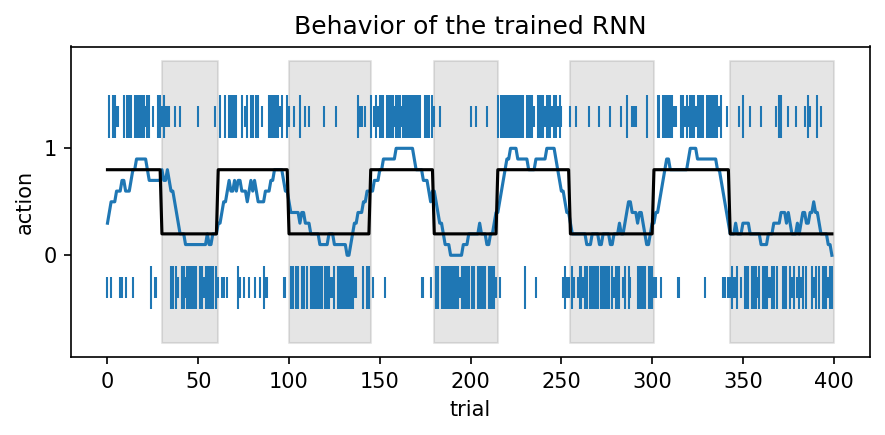

In [57]:
# plot the behavior from example session

def shading_blocks(ax, info):

    y_min, y_max = ax.get_ylim()
    block_start = 0
    for block_ind in range(len(info['block_lens'])):
        if block_ind % 2 == 1:
            ax.fill_between(
                [block_start, block_start+info['block_lens'][block_ind]],
                y_min, y_max,
                color='gray', alpha=0.2
            )
        block_start += info['block_lens'][block_ind]

        
fig, ax = plt.subplots(1,1, figsize=(6, 3), dpi=150)
ax.set_title(f'Behavior of the trained RNN')

# event raster
events = []
for act in range(action_dim):
    # 0: action 0, 1: action 1
    for rew in [0, 1]:
        events_act_rew = np.where(
            (actions==act) & (rewards==rew))[0]
        events.append(events_act_rew)
line_offsets = [-0.3,-0.3] + [1.3,1.3]
line_lengths = [0.2,0.4] + [0.2,0.4]
ax.eventplot(events, lineoffsets=line_offsets, 
            linelengths=line_lengths, linewidth=1)

# action running average
running_average_window = 10
actions_moving_average = np.convolve(
    np.array(actions), np.ones(running_average_window), mode="same") \
        / running_average_window
ax.plot(
    np.arange(len(actions_moving_average)), 
    actions_moving_average
)

# block reward prob: action 1
# get blocks
rew_prob_a1 = []
for block_idx, block_len in enumerate(info['block_lens']):
    for trial_idx in range(block_len):
        rew_prob_a1.append(info['reward_prob'][block_idx][1])
block_reward_prob_color = 'k'
            
ax.plot(
    np.arange(len(rew_prob_a1)),
    rew_prob_a1, 
    c=block_reward_prob_color
)
shading_blocks(ax, info)

ax.set_xlabel('trial')
ax.set_ylabel('action')
ax.set_yticks([0, 1], [0, 1])

fig.tight_layout()

(0.0, 1.0)

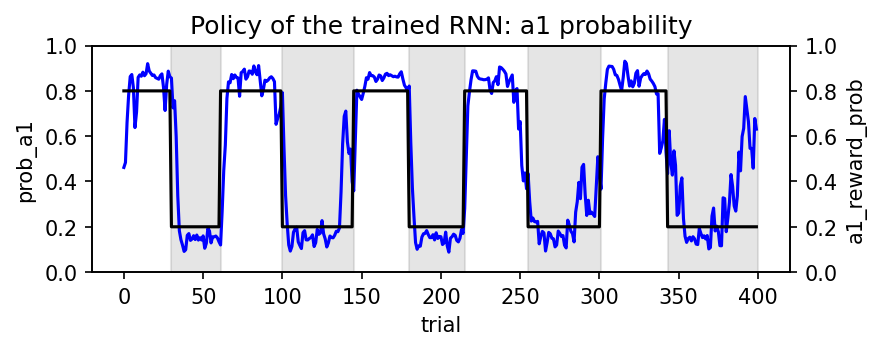

In [58]:
# plot the output: policy or action probability

fig, ax = plt.subplots(1,1, figsize=(6, 2), dpi=150)
ax.set_title(f'Policy of the trained RNN: a1 probability')

colors = ['b']

arr = a1_probs
ax.plot(np.arange(len(arr)), arr, label='prob_a1', color=colors[0])

ax.set_xlabel('trial')
ax.set_ylabel('prob_a1')
ax.set_ylim(0, 1)

shading_blocks(ax, info)

# block reward prob: action 1
ax = ax.twinx()
ax.plot(
    np.arange(len(rew_prob_a1)),
    rew_prob_a1, 
    c=block_reward_prob_color
)
ax.set_ylabel('a1_reward_prob', c=block_reward_prob_color)
ax.tick_params(axis='y', labelcolor=block_reward_prob_color)
ax.set_ylim(0, 1)


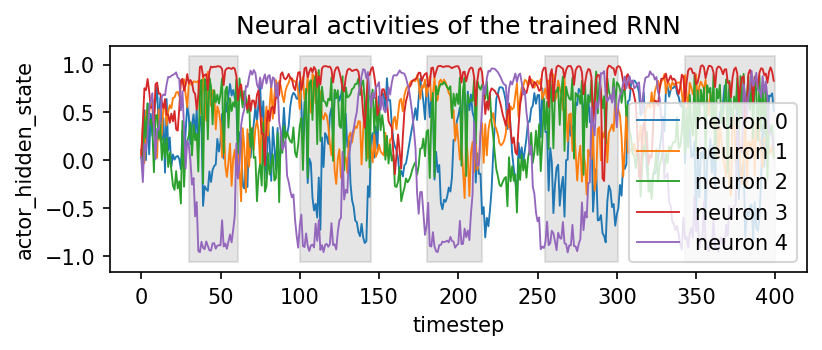

In [59]:
# plot RNN activity
n_hidden_units_plot = 5

fig, ax = plt.subplots(1,1, figsize=(6, 2), dpi=150)
ax.set_title(f'Neural activities of the trained RNN')

for plot_id in range(n_hidden_units_plot):
    arr = actor_hidden_states[:, plot_id]
    ax.plot(arr, lw=0.9, label=f'neuron {plot_id}')

shading_blocks(ax, info)

ax.set_xlabel('timestep')
ax.set_ylabel('actor_hidden_state')
ax.legend()

In [13]:
# EXERCISE: plot the above for another session
# discussion: what's the difference between each session?

## 3. Visualize RNN activities using PCA

To better visualize and understand network dynamics of the trained network, we can apply dimensionality reduction methods to extract relevant dimensions within the high-dimensional neural activity space. 
One example method is principal component analysis (PCA), which captures the dimensions that explain the most variances within our dataset.

In [60]:
# load training set: 20 sessions
with open(f'./utils/info_training_set.pickle', 'rb') as f:
    info_training_set = pickle.load(f)

actions_training_set = np.load('./utils/actions_training_set.npy')
rewards_training_set = np.load('./utils/rewards_training_set.npy')
a1_probs_training_set = np.load('./utils/a1_probs_training_set.npy')
actor_hidden_states_training_set = np.load('./utils/actor_hidden_states_training_set.npy')

In [61]:
# PCA on the training set
from sklearn.decomposition import PCA

num_components = 8

pca_model_actor = PCA(n_components=num_components)
pca_model_actor.fit(actor_hidden_states_training_set.reshape(-1, rnn_hidden_dim))

print(f'PCA explained variance: {pca_model_actor.explained_variance_ratio_}')

PCA explained variance: [0.36337733 0.24029204 0.0824874  0.07456451 0.0534902  0.04326024
 0.02841571 0.02288719]


(0.0, 1.0)

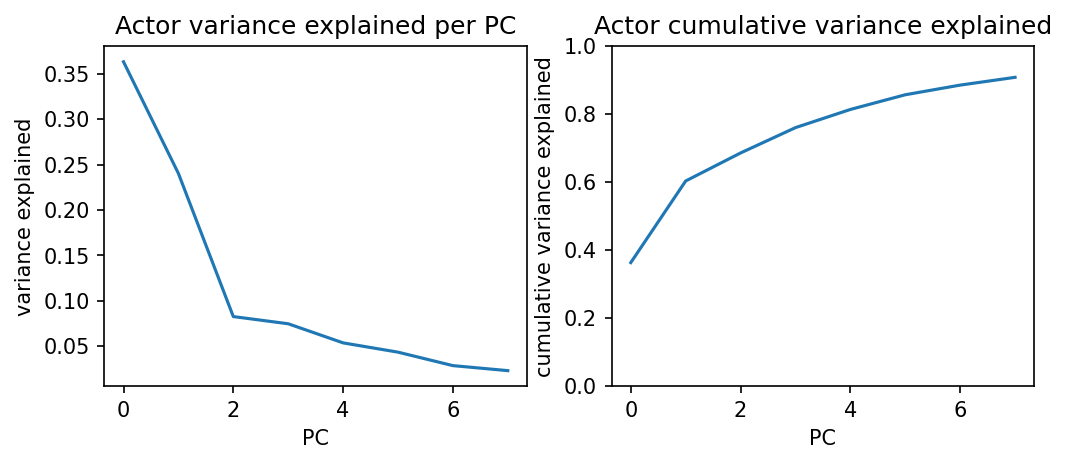

In [62]:
# cumulative variance explained
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), dpi=150)

ax = axs[0]
ax.plot(pca_model_actor.explained_variance_ratio_)
ax.set_title('Actor variance explained per PC')
ax.set_xlabel('PC')
ax.set_ylabel('variance explained')

ax = axs[1]
ax.plot(np.cumsum(pca_model_actor.explained_variance_ratio_))
ax.set_title('Actor cumulative variance explained')
ax.set_xlabel('PC')
ax.set_ylabel('cumulative variance explained')
ax.set_ylim(0, 1)

In [63]:
# transform
transformed_actor_hidden_states_training_set = pca_model_actor.transform(
    actor_hidden_states_training_set.reshape(-1, rnn_hidden_dim))
transformed_actor_hidden_states_training_set = transformed_actor_hidden_states_training_set.reshape(
    -1, total_trials, num_components)

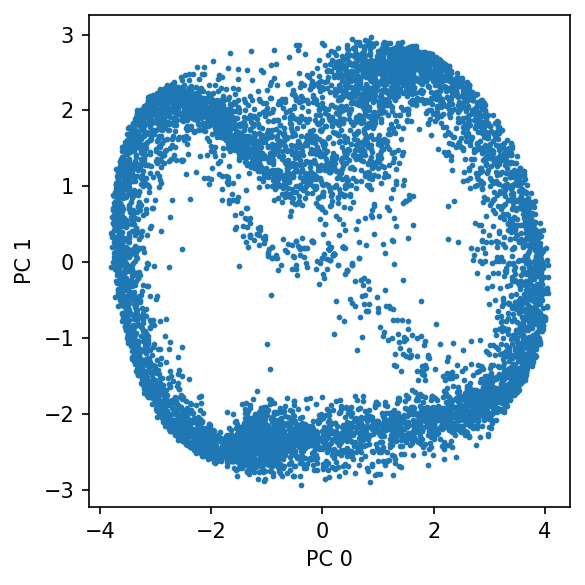

In [64]:
# visualize the first two PCs
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=150)

pc_x = 0
pc_y =1

scatter = ax.scatter(
    transformed_actor_hidden_states_training_set[:, :, pc_x],
    transformed_actor_hidden_states_training_set[:, :, pc_y],
    s=3.0
#     c=a1_probs_all, cmap=cm.bwr,
#     vmin=0, vmax=1,
)

ax.set_xlabel(f'PC {pc_x}')
ax.set_ylabel(f'PC {pc_y}')
# fig.colorbar(scatter, ax=ax)

fig.tight_layout()

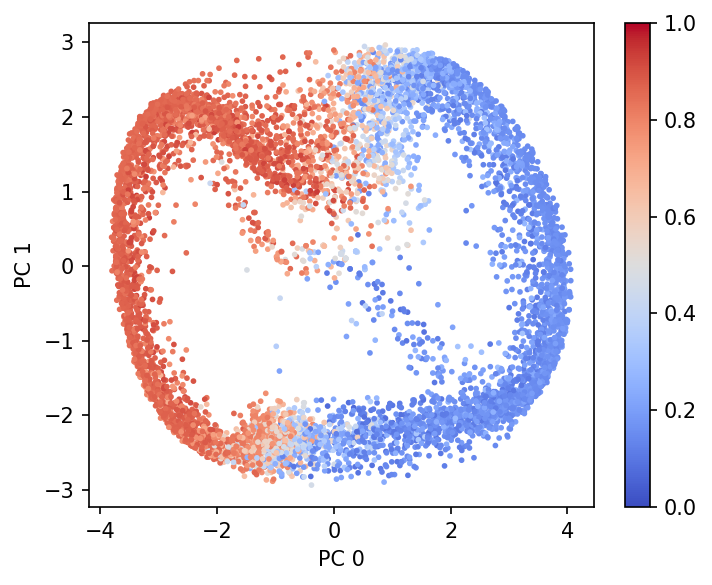

In [65]:
# visualize the first two PCs: color-code by a1_prob
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=150)

pc_x = 0
pc_y =1

scatter = ax.scatter(
    transformed_actor_hidden_states_training_set[:, :, pc_x],
    transformed_actor_hidden_states_training_set[:, :, pc_y],
    s=3.0,
    c=a1_probs_training_set, cmap=cm.coolwarm,
    vmin=0, vmax=1,
)

ax.set_xlabel(f'PC {pc_x}')
ax.set_ylabel(f'PC {pc_y}')
fig.colorbar(scatter, ax=ax)

fig.tight_layout()

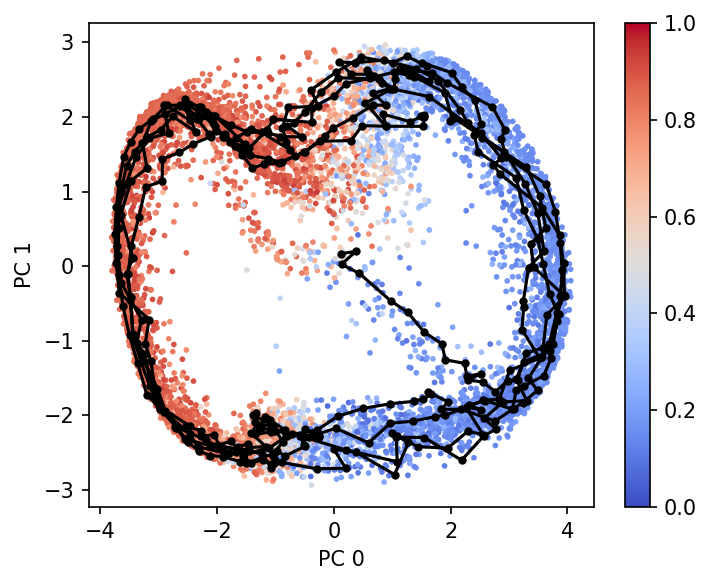

In [20]:
# PCA on the testing set: visualize the first two PCs
# Let's see how one test episode rollsout: again, use the first session in the test set
# recall the test roll out above

# transform the test set first
transformed_actor_hidden_states_testing_set = pca_model_actor.transform(
    actor_hidden_states_training_set.reshape(-1, rnn_hidden_dim))
transformed_actor_hidden_states_testing_set = transformed_actor_hidden_states_testing_set.reshape(
    -1, total_trials, num_components)


# how many steps to visualize
trial_end = 400

fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=150)

pc_x = 0
pc_y =1

scatter = ax.scatter(
    transformed_actor_hidden_states_training_set[:, :, pc_x],
    transformed_actor_hidden_states_training_set[:, :, pc_y],
    s=3.0,
    c=a1_probs_training_set, cmap=cm.coolwarm,
    vmin=0, vmax=1,
)
ax.plot(
    transformed_actor_hidden_states_testing_set[example_session_id, :trial_end, pc_x],
    transformed_actor_hidden_states_testing_set[example_session_id, :trial_end, pc_y],
    color='k', marker='o', ms=3
)

ax.set_xlabel(f'PC {pc_x}')
ax.set_ylabel(f'PC {pc_y}')
fig.colorbar(scatter, ax=ax)

fig.tight_layout()

In [21]:
# EXERCISE: play with the trial_end parameter above, explore how the RNN activities evolve in this PC space

In [22]:
# EXERCISE: visualize other PCs, what do you find?

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import imageio
import io

def create_frame(elev, azim, axes_set = [0,1,2], frame = -1):

    if frame > np.shape(transformed_actor_hidden_states_testing_set)[1]:
        frame = np.shape(transformed_actor_hidden_states_testing_set)[1]
        
    fig = plt.figure(figsize=(10, 8), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(
        transformed_actor_hidden_states_training_set[:, :, axes_set[0]],
        transformed_actor_hidden_states_training_set[:, :, axes_set[1]],
        transformed_actor_hidden_states_training_set[:, :, axes_set[2]],
        s=40.0,
        c=a1_probs_training_set, cmap=cm.coolwarm,
        vmin=0, vmax=1, alpha = .2
    )
    
    ax.plot(
        transformed_actor_hidden_states_testing_set[example_session_id, :frame, axes_set[0]],
        transformed_actor_hidden_states_testing_set[example_session_id, :frame, axes_set[1]],
        transformed_actor_hidden_states_testing_set[example_session_id, :frame, axes_set[2]],
        color='k', alpha = .5,linewidth = 3
    )

    for tw in range(5):
        frametail = np.max(frame - tw,0)
        ax.plot(
            transformed_actor_hidden_states_testing_set[example_session_id, frametail:frame+1, axes_set[0]],
            transformed_actor_hidden_states_testing_set[example_session_id, frametail:frame+1, axes_set[1]],
            transformed_actor_hidden_states_testing_set[example_session_id, frametail:frame+1, axes_set[2]],
            color='k', alpha = .5, linewidth = 10 - tw
        )
    
    ax.plot(
        transformed_actor_hidden_states_testing_set[example_session_id, frame, axes_set[0]],
        transformed_actor_hidden_states_testing_set[example_session_id, frame, axes_set[1]],
        transformed_actor_hidden_states_testing_set[example_session_id, frame, axes_set[2]],
        color='k', marker='o', ms=15, alpha = .8
    )    
    
    ax.set_xlabel('PC '+str(axes_set[0]))
    ax.set_ylabel('PC '+str(axes_set[1]))
    ax.set_zlabel('PC '+str(axes_set[2]))
    
    fig.colorbar(scatter, ax=ax, label='Probability of Licking Right')
    
    ax.view_init(elev=elev, azim=azim)
    ax.grid(False)
    
    fig.tight_layout()
    
    # Save the plot to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    
    plt.close(fig)
    
    return buf

# Create frames
def make_mov(n_frames=360, azim_start=60, axes_set=[0,1,2]):
    frames = []
    fig = plt.figure(figsize=(10, 8), dpi=150)
    ax = fig.add_subplot(111, projection='3d')

    for i in range(n_frames):
        # Clear the previous frame
        ax.clear()

        # Calculate elevation and azimuth for this frame
        elev = 30 + 30 * np.sin(2 * np.pi * i / 360)
        azim = azim_start + 360 * i / 360  # Full 360 degree rotation

        # Create the frame
        buf = create_frame(elev, azim, axes_set=axes_set, frame=i)
        frame = imageio.v2.imread(buf)
        frames.append(frame)

        # Update progress
        if i % 10 == 0:
            print(f"Processed frame {i}/{n_frames}")

    # Save as GIF
    axes_set_str = '_'.join(str(x) for x in axes_set)
    imageio.mimsave(f'rotating_3d_plot_2rotationaxes{axes_set_str}.gif', frames, fps=5)

    plt.close(fig)

In [35]:
make_mov(n_frames = 60,azim_start = 0,axes_set = [0,1,2])

Processed frame 0/60
Processed frame 10/60
Processed frame 20/60
Processed frame 30/60
Processed frame 40/60
Processed frame 50/60


## 4. Dynamical systems analysis of RNN

### Finding approximate fixed points
Here we aim to find approximate fixed points. For a given dynamical system (e.g. the trained RNN),
\begin{align}
    \frac{d\mathbf{x}}{dt} = F(\mathbf{x}),
\end{align}

We can find approximated fixed points by minimizing
\begin{align}
    \mathrm{argmin}_{\mathbf{x}}  q = \frac{1}{2} (F(\mathbf{x}))^2.
\end{align}

Because there are four different input conditions (prev_action, prev_reward) for our task: (0, 1), (0, 0), (1, 0), (1, 1), we can find fixed points of the trained RNN under these conditions respectively.

In [67]:
# Discuss & Issue
# Discuss: Do we want to go through implementation of fixed point finding here? Or just stay conceptual?
# consideration 1: minimization takes a while

# Issue: can't seem to install pytorch in this container yet?

# Proposal: we can go through the steps for fixed point finding conceptually, 
# but leave the implementation to exercise: 
# initialize along the trajecotry/ speculated regions --> minimize q --> 
# save when it meets the pre-defined q threshold

# Hence here I provide pre-computed fixed points, computed with q_threshold=0.001

In [68]:
# load the pre-computed fixed points
with open(f'./utils/fixed_points_per_condition.pickle', 'rb') as f:
    fixed_points_per_condition = pickle.load(f)

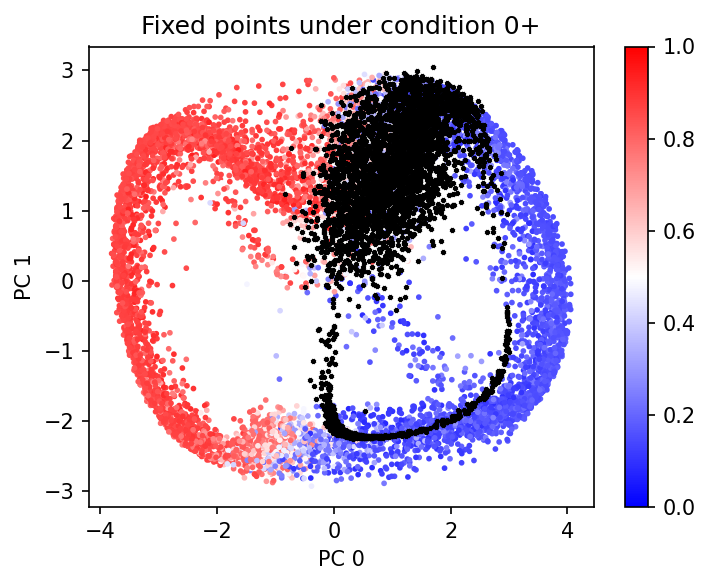

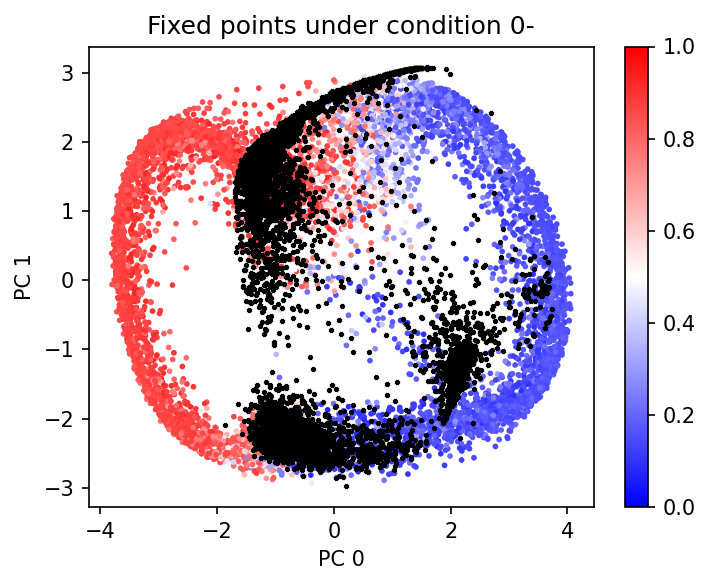

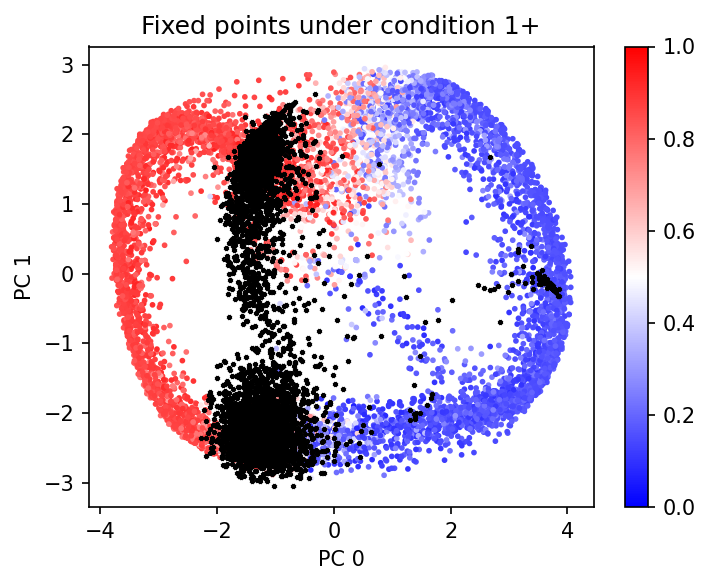

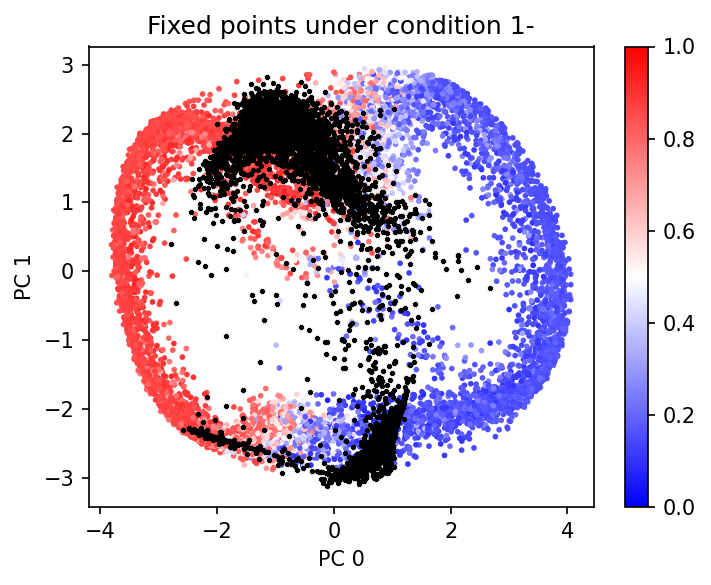

In [69]:
# visualize the fixed points under different input conditions in the PC space

# input condition
# (0,1) labeled 0+
# (0,0) labeled 0-
# (1,1) labeled 1+
# (1,0) labeled 1-

for condition in ['0+', '0-', '1+', '1-']:
    
    # transform fixed points
    fixed_points = fixed_points_per_condition[condition]
    transformed_fixed_points = pca_model_actor.transform(
        fixed_points.reshape(-1, rnn_hidden_dim))

    
    # plot
    fig, ax = plt.subplots(1,1, figsize=(5, 4), dpi=150)
    ax.set_title(f'Fixed points under condition {condition}')
    # plot 0
    pc_x = 0
    pc_y =1
    
    scatter = ax.scatter(
        transformed_actor_hidden_states_training_set[:, :, pc_x],
        transformed_actor_hidden_states_training_set[:, :, pc_y],
        c=a1_probs_training_set, cmap=cm.bwr,
        vmin=0, vmax=1,
        s=3.0
    )
    ax.scatter(
        transformed_fixed_points[:, pc_x],
        transformed_fixed_points[:, pc_y],
        color='k', marker='x', s=3
    )
    ax.set_xlabel(f'PC {pc_x}')
    ax.set_ylabel(f'PC {pc_y}')
    fig.colorbar(scatter, ax=ax)

    fig.tight_layout()

